In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import os
import warnings
import os, sys
import numpy as np
import keras
import cv2
from skimage import io,transform
from tflearn.layers.conv import global_avg_pool
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import Callback

C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
def VGG16(input_tensor=None, input_shape=None):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)


    # Classification block
    x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fca')(x)
    x = Dense(4096, activation='relu', name='fcb')(x)
    x = Dense(40, activation='softmax', name='Classification')(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    return model

In [3]:
def loading(dirs = os.getcwd()):

    trainMatrix = []
    trainLabel = []
    testMatrix = []
    testLabel = []
    countOfPeople = 0
    for i in range(1, 40):
        if i == 14:
            continue
        file = os.path.join(dirs, 'CroppedYale', 'yaleB%02d' % i, '*.pgm')
        rawImg = io.imread_collection(file)
        
        imgs = np.array([cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC) for img in rawImg])
        imgs = np.array(imgs, dtype=np.int64)
        
        countOfPeople = len(imgs)
        #print(countOfPeople)
        
        train = imgs[0:35]
        trainMatrix.append(train)
        for j in range(0, 35): trainLabel.append(i)
            
        
        
        test = imgs[countOfPeople-30:countOfPeople]
        testMatrix.append(test)
        for j in range(0, 30): testLabel.append(i) 
            
            
        
        

        
    return trainMatrix, trainLabel, testMatrix, testLabel

In [4]:
trainMatrix, trainLabel, testMatrix, testLabel = loading(os.getcwd())


trainCount = np.size(trainLabel, 0)
testCount = np.size(testLabel, 0)



trainMatrix = np.array(trainMatrix).reshape(trainCount,224,224,1)
testMatrix = np.array(testMatrix).reshape(testCount,224,224,1)

print("TrainCount: %d" % trainCount)
print("TestCount: %d\n" % testCount)

TrainCount: 1330
TestCount: 1140



In [5]:
trainLabel_encode = np_utils.to_categorical(trainLabel, num_classes=40)
testLabel_encode = np_utils.to_categorical(testLabel, num_classes=40)
print(trainLabel_encode)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=1)
        print('Testing loss: %.4f, acc: %.4f\n' %(loss, acc))

In [7]:
model = VGG16(input_shape=[224, 224, 1])
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(trainMatrix, trainLabel_encode, epochs=30, batch_size=32, 
                    callbacks=[TestCallback((testMatrix, testLabel_encode))], verbose=1)

Epoch 1/30
1140/1140 [==============================] - 12s 11ms/step
Testing loss: 3.6774, acc: 0.0298

Epoch 2/30
1140/1140 [==============================] - 11s 9ms/step
Testing loss: 3.6547, acc: 0.0325

Epoch 3/30
1140/1140 [==============================] - 10s 9ms/step
Testing loss: 3.6416, acc: 0.0728

Epoch 4/30
1140/1140 [==============================] - 11s 9ms/step
Testing loss: 3.6701, acc: 0.0728

Epoch 5/30
1140/1140 [==============================] - 10s 9ms/step
Testing loss: 3.8413, acc: 0.0798

Epoch 6/30
1140/1140 [==============================] - 10s 9ms/step
Testing loss: 3.5797, acc: 0.2342

Epoch 7/30
1140/1140 [==============================] - 11s 9ms/step
Testing loss: 4.0859, acc: 0.3035

Epoch 8/30
1140/1140 [==============================] - 10s 9ms/step
Testing loss: 4.6051, acc: 0.3202

Epoch 9/30
1140/1140 [==============================] - 10s 9ms/step
Testing loss: 4.9763, acc: 0.2825

Epoch 10/30
1140/1140 [==============================] - 10s 9m

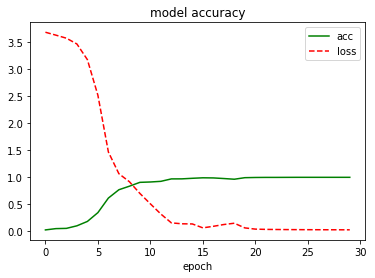

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], 'g', label='acc')
plt.plot(history.history['loss'], 'r', linestyle='--', label='loss')
plt.legend(loc='upper right')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.show()

In [9]:
loss, acc = model.evaluate(x = testMatrix, y = testLabel_encode, batch_size = 32)
print("loss : ", loss)
print("accuracy : ", acc)

1140/1140 [==============================] - 10s 9ms/step
loss :  7.082463712859572
accuracy :  0.4184210527361485
